In [1]:
%matplotlib inline

import matplotlib.pyplot as plt

In [2]:
import os
os.environ['CXX'] = 'g++'

In [3]:
import arviz
import numpy as np
import pymc3 as pm
from tqdm import tqdm

In [4]:
from IPython.display import display

In [5]:
import scipy.stats.distributions as dist

In [6]:
def get_quantile(density, bins, q):
    cumsums = np.cumsum(density * (bins[1:] - bins[:-1]))
    
    bin_index = np.nonzero(cumsums>=q)[0][0]
    # report center of bin
    return (bins[bin_index] + bins[bin_index+1]) * 0.5

In [7]:
def beta_a(mean, var):
    assert var < mean*(1-mean)
    
    return mean*(mean*(1-mean)/var-1)

def beta_b(mean, var):
    assert var < mean*(1-mean)
    
    return (1 - mean) * (mean*(1-mean)/var-1)

def beta_params(mean, var):
    return {
        'alpha': beta_a(mean, var),
        'beta': beta_b(mean, var),
    }

# First Model:

We first infer a posterior over the infection fatality rate as follows:
We model the infection rate in gangelt as a beta distribution that captures the uncertainty that the study authors report.
The number of infections in Gangelt is then modelled as binomially distributed depending on the infection rate eand the (fixed) number of people in Gangled.
The number of fatalities is modelled as bionomially distributed depending on the infection fatality rate and the number of infections with a weak beta prior in the infection fatality rate.

After computing the posterior over the infection fatality rate, we model the infections in germany as a negative binomial distribution depending on the infection fatality rate that and the number of deaths in germany.

In [8]:
# todo: beta prior for infection rate (compute with method of moments)
#       beta prior for infection fatality rate (mean=0.1, std>0.1)


# run models with weak priors and with priors that encode what we knew before.
# do sensitivity analysis for priors

# try beta prior over german infected rate and define infected as bernoulli
# compare with sampling negative binomial

# put into private github repo

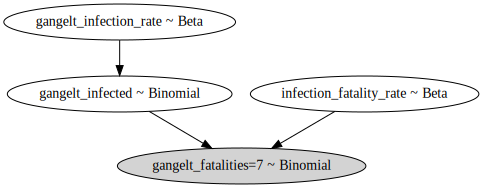

In [9]:
with pm.Model() as model:
    # the infection rate is given as 0.1553 [0.1231, 0.1896].
    gangelt_infection_rate = pm.Beta(**beta_params(mean=0.1553, var=((0.1896-0.1231)/4)**2), name='gangelt_infection_rate')
    
    total_population = 12597
    gangelt_infected = pm.Binomial(n=total_population, p=gangelt_infection_rate, name='gangelt_infected')
    
    infection_fatality_rate = pm.Beta(**beta_params(mean=0.1, var=0.1**2), name='infection_fatality_rate')
    gangelt_fatalities = pm.Binomial(n=gangelt_infected, p=infection_fatality_rate, name='gangelt_fatalities=7', observed=7)    
    display(pm.model_graph.model_to_graphviz(model))

### Inspecting the priors

let's have a look into the priors to see whether they align with our intuitions and are not too narrow

In [10]:
with model:
    prior = pm.sample_prior_predictive(samples=50000)

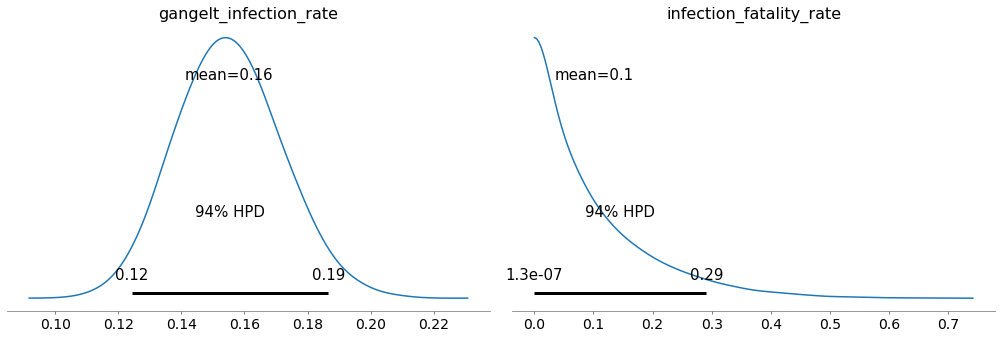

In [11]:
arviz.plot_posterior(prior, var_names=[
    'gangelt_infection_rate',
    'infection_fatality_rate',
]);

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fd4543650d0>],
      dtype=object)

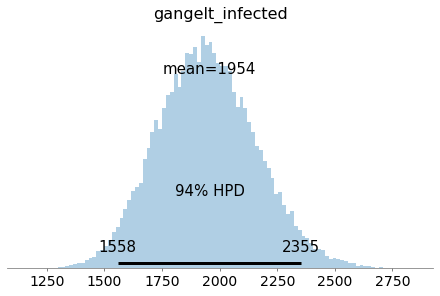

In [12]:
arviz.plot_posterior(prior, var_names=[
    'gangelt_infected',
], bins=100)

## Sampling the posterior

In [13]:
# this allows to continue sampling by executing the next cell repeatedly
posterior = None

In [14]:
with model:
    posterior = pm.sample(draws=100000, trace=posterior)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [infection_fatality_rate, gangelt_infection_rate]
>Metropolis: [gangelt_infected]
Sampling 4 chains, 1,830 divergences: 100%|██████████| 402000/402000 [02:44<00:00, 2439.65draws/s]
There were 1830 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.2519998379711901, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


In [16]:
pm.summary(posterior)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
gangelt_infected,1940.172,211.053,1539.000,2331.000,4.505,3.193,2195.0,2185.0,2206.0,4070.0,1.0
gangelt_infection_rate,0.154,0.016,0.123,0.185,0.000,0.000,2234.0,2224.0,2245.0,4279.0,1.0
infection_fatality_rate,0.004,0.002,0.001,0.007,0.000,0.000,20993.0,20993.0,20957.0,52759.0,1.0


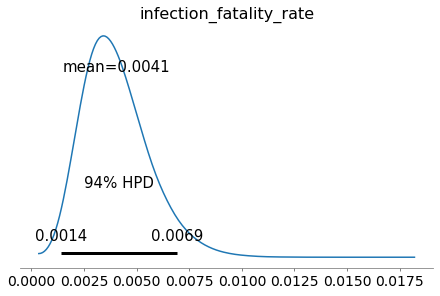

In [18]:
arviz.plot_posterior(posterior, var_names=[
    'infection_fatality_rate'
], bins=100);

## Sampling the number of infections in Germany with a negative binomial distribution

In [20]:
german_infected = [dist.nbinom(n=6575, p=p).rvs() for p in (posterior['infection_fatality_rate'])]

(500000.0, 5000000.0)

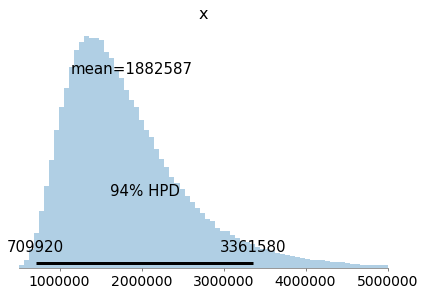

In [21]:
arviz.plot_posterior(np.array(german_infected), bins=300);
plt.xlim(5e5, 5e6)